In [2]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm

import textwrap
import seaborn

## define colors used in bars

In [5]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

# import data directly from google sheets

In [6]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
#spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
#spreadsheet = gc.open_by_key('1IQ_g9PCr6pexDvEBoi5jboNfamJtPQ63ezxyq0qRsu0') # specific doc for briefing
spreadsheet = gc.open_by_key('1YeYmh43_DvVI4DWpEvVPt3IUr3XzP4h4-X1FSf0Kew8')

#spreadsheet[1] "Gas Pipelines" tab is the second index
gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [7]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

## for offline excel file (when you gotta do work without internet)

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [8]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']
country_ratios_df.replace('--', numpy.nan, inplace=True)

# km by country, km by region calculations

In [9]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(country_ratios_df['Country'])))
region_list = sorted(list(set(country_ratios_df['Region'])))

In [10]:
country_ratios_oil_df = country_ratios_df[country_ratios_df['Fuel']=='Oil']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    km_by_country_df[status] = country_ratios_oil_df_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    km_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [11]:
km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [12]:
km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_country_df = km_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

## add Total row to km by country/region

# projects by country, by region

In [13]:
country_ratios_oil_df = country_ratios_df[country_ratios_df['Fuel']=='Oil']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    num_by_country_df[status] = country_ratios_oil_df_status.groupby('ProjectID')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    num_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


# numbers of pipes finished in a given year

In [15]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Oil')]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [16]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['Operating'])) &
                              (pipes_started_startyear['Fuel']=='Oil')]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [17]:
# indev pipelines = Proposed or Construction
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev[pipes_indev['Fuel']=='Oil']
pipes_indev = pipes_indev.loc[(pipes_indev.StartYearEarliest>2022)|
                              (pipes_indev.StartYearEarliest.isna())].groupby('Status')['LengthMergedKm'].sum()

In [18]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030[(pipes_indev_to2030['Fuel']=='Oil') &
                                        (pipes_indev_to2030['Status'].isin(['Proposed','Construction','Shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2023,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()


In [19]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
                                              (pipes_indev_startyear['Fuel']=='Oil')]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'])['LengthMergedKm'].sum()


## Fig 2 again - 2023–2030, go back to 2008

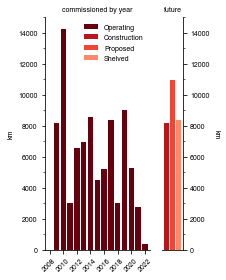

In [20]:
font_size = 7

ytop = 15000
ytop2 = 15000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2022.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, pipes_indev[s],
                 color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])


ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)
#fig.subplots_adjust(wspace=0.05, hspace=None)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

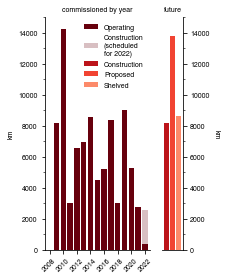

In [21]:
font_size = 7

ytop = 15000
ytop2 = 15000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.bar(2022,pipes_indev_startyear['Construction',2022],
       label='Construction\n(scheduled\nfor 2022)', bottom=pipes_started_sum.loc[2022], 
       facecolor=tracker_operating, alpha=0.25)
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2022.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    if s in ['Proposed','Shelved']:
        ax2_list.append(ax2.bar(x, pipes_indev[s]+pipes_indev_startyear[s,2022],
                 color=c, label=s))
    else:
        ax2_list.append(ax2.bar(x, pipes_indev[s],
                 color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])


ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008-with-2022.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008-with-2022.pdf', bbox_inches='tight', transparent=True)

## plus/minus 8 years

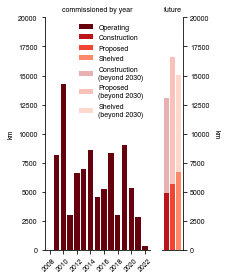

In [22]:
font_size = 7

ytop = 20000
ytop2 = 20000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2022.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
status_alt = ['Construction\n(beyond 2030)', 'Proposed\n(beyond 2030)', 'Shelved\n(beyond 2030)']
ax2_list = []

for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, pipes_indev_to2030[s],
             color=c, label=s))

for x,c,s,s_alt in zip(xvals,colors,status,status_alt):
    ax2_list.append(ax2.bar(x, pipes_indev[s], bottom=pipes_indev_to2030[s],
             color=c, label=s_alt, alpha=0.333))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

#ax2.set_xlabel('possible\nfuture', size=font_size)
#ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')
#ax2.set_yticklabels([])
#ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)
#fig.subplots_adjust(wspace=0.05, hspace=None)

#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-plusminus-8yrs.png', bbox_inches='tight', transparent=True, dpi=600)
#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-plusminus-8yrs.pdf', bbox_inches='tight', transparent=True)

## percent pipelines with start date (sanity check)

In [23]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Oil') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [24]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


0.5825242718446602

## regional pipelines started in given year

In [25]:
years_array = numpy.arange( float(pipes_df_orig['StartYearEarliest'].min()), float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [26]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='Gas']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='Oil')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

In [27]:
if len(region_list)!=10:
    region_list = region_list[2:]

## plot pie chart of regional values

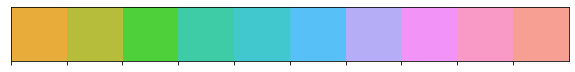

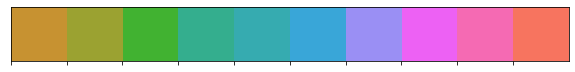

In [28]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, s=0.9, l=0.75, h=0.15))
seaborn.palplot(seaborn.husl_palette(10, h=0.15))

cmap_dark = seaborn.husl_palette(10, h=0.15, l=0.4, s=0.8, as_cmap=True)
cmap_light = seaborn.husl_palette(10, h=0.15, s=1, as_cmap=True)

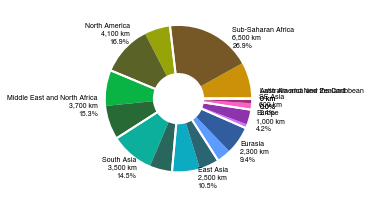

In [29]:
font_size=7

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

nwedges = region_list.__len__()
region_order = km_by_region_df.index[:nwedges]

pie_vals = km_by_region_df.loc[region_order]['Proposed+Construction'].values
pie_labels = km_by_region_df.index
pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-2)):,} km')
pie_labels_perc = (km_by_region_df.loc[region_order]['Proposed+Construction'] / 
                   km_by_region_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f'\n{x:.1f}%')

# ****************************************
pie_vals_separated = km_by_region_df.loc[region_order][['Construction','Proposed']].values.flatten()
#pie_labels_separated = numpy.array(list(zip(km_by_region_df.index[:-1],km_by_region_df.index[:-1]))).flatten()
#pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-3)):,} km')

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(0,1,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(0,1,nwedges))

pie_labels = [i+j+k for i,j,k in zip(pie_labels, pie_labels_km, pie_labels_perc)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_light_10, cmap_dark_10)).reshape(20,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/oil-pipelines_pie-graph-country-pipelines-km.pdf', bbox_inches='tight', transparent=True)

#mp.savefig('saved-figures/oil-pipelines_pie-graph-country-pipelines-km.png', 
#           bbox_inches='tight', 
#           transparent=True,
#           dpi=600)

# top 20 countries proposed+construction

In [30]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

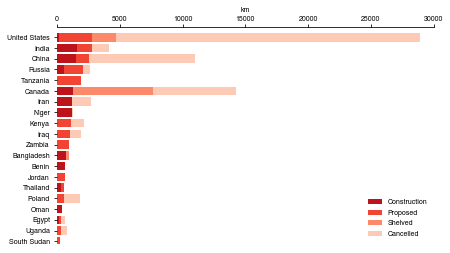

In [31]:
font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,#solar_yellow, 
        label='Proposed')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,#'0.75', 
        label='Shelved')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,#'0.9', 
        label='Cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,30000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/oil-pipelines_top-20-countries.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf',
          bbox_inches='tight', 
          transparent=True)

# top 20 without cancelled and shelved bars

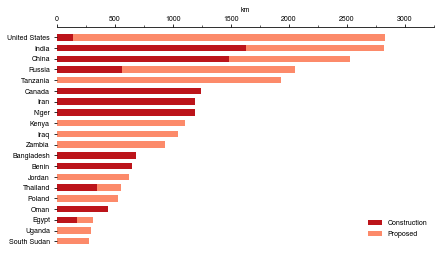

In [32]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
#tracker_operating = sel_cmap(0.999)
#tracker_construction = sel_cmap(0.8)
#tracker_proposed = sel_cmap(0.6)
#tracker_shelved = sel_cmap(0.4)
#tracker_cancelled = sel_cmap(0.2)

font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.8),
        label='Construction', height=0.6)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.4),
        label='Proposed', height=0.6)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,3250)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))


#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.pdf',
          bbox_inches='tight', 
          transparent=True)

In [33]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

0.8968378186968838

# parent analysis

In [34]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in pipes_df_orig.loc[pipes_df_orig.Fuel=='Oil'].iterrows():
    parent_string = row.Parent
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have a Owner [%] syntax
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    for p_idx,parent in enumerate(parent_list):
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'Country':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'Status':row.Status,
                                                                         'LengthMergedKm':row.LengthMergedKm,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnership'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.LengthMergedKm
owner_parent_calculations_df['CapacityOwnership'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.CapacityBOEd

### companies invested in Russian infrastructure?

it's really just ProjectIDs 2044 (Caspian Oil Pipeline), 3675 (Vostok Oil Pipeline), and 3679 (Sabo-Dagi Oil Pipeline)

In [36]:
# project IDs of pipelines that pass through Russia and are construction/proposed
russian_indev_projectids = country_ratios_oil_df.loc[(country_ratios_oil_df.Status.isin(['Proposed','Construction']))&
                                                     (country_ratios_oil_df.Country=='Russia')]['ProjectID'].unique()
#russian_indev_projectids
russian_indev_op_df = owner_parent_calculations_df.loc[owner_parent_calculations_df.ProjectID.isin(russian_indev_projectids)]
russian_indev_op_df.loc[russian_indev_op_df.Country!='Russia']



,Parent,ProjectID,FractionOwnership,Country,Status,LengthMergedKm,CapacityBOEd,KmOwnership,CapacityOwnership
0,Samruk-Kazyna SWF JSC,P2044,0.1980,Kazakhstan,Construction,0.00,319478.90,0.00,63256.82220
0,Chevron,P2044,0.1500,United States,Construction,0.00,319478.90,0.00,47921.83500
0,ExxonMobil,P2044,0.0750,United States,Construction,0.00,319478.90,0.00,23960.91750
0,Shell,P2044,0.0750,United Kingdom,Construction,0.00,319478.90,0.00,23960.91750
0,Eni S.p.A.,P2044,0.0200,Italy,Construction,0.00,319478.90,0.00,6389.57800
0,BP,P2044,0.0088,United Kingdom,Construction,0.00,319478.90,0.00,2811.41432
0,National Bank of the Republic of Kazakhstan,P2044,0.0008,Kazakhstan,Construction,0.00,319478.90,0.00,255.58312
0,Nord Axis,P3675,0.1000,China,Proposed,800.00,NaN,80.00,NaN
0,Vitol,P3675,0.0375,Switzerland,Proposed,800.00,NaN,30.00,NaN
0,MME,P3675,0.0125,Singapore,Proposed,800.00,NaN,10.00,NaN


## biggest parent companies for in-dev stuff?

In [37]:
pandas.DataFrame(
    owner_parent_calculations_df.loc[
        owner_parent_calculations_df.Status.isin(['Proposed','Construction','Country'])].groupby(
        'Parent')['KmOwnership'].sum()).sort_values('KmOwnership', ascending=False)[:20]

,KmOwnership
Parent,
China National Petroleum Corporation,1950.000000
Iraq Ministry of Oil,1665.000000
Numaligarh Refinery Limited,1630.000000
TotalEnergies SE,1287.698333
Indian Oil Corporation,1194.000000
Iran Ministry of Petroleum,1193.000000
Rosneft,1190.000000
Government of Zambia,1140.570000
Canada Development Investment Corporation,980.000000


In [38]:
pandas.DataFrame(
    owner_parent_calculations_df.loc[
        owner_parent_calculations_df.Status.isin(['Proposed','Construction'])].groupby(
        ['Parent','Country'])[['KmOwnership','CapacityOwnership']].sum(min_count=1)).sort_values('KmOwnership', ascending=False)[:20]

,,KmOwnership,CapacityOwnership
Parent,Country,,
China National Petroleum Corporation,China,1950.000000,90000.000000
Iraq Ministry of Oil,Iraq,1665.000000,1000000.000000
Numaligarh Refinery Limited,India,1630.000000,NaN
TotalEnergies SE,France,1287.698333,203503.333333
Indian Oil Corporation,India,1194.000000,430067.750000
Iran Ministry of Petroleum,Iran,1193.000000,750000.000000
Rosneft,Russia,1190.000000,11980.458750
Government of Zambia,Zambia,1140.570000,14674.000000
Canada Development Investment Corporation,Canada,980.000000,290000.000000


### how many of the projects for each owner do we have capacity data for? (add fraction)

## emissions estimates

In [39]:
# kuhne paper
co2_rate = 152.789 # number is 152,789 tCO2/year emissions per kilobarrel per day, divide by 1000 to get per bpd (bpd=BOEd)

In [40]:
# calculate the number of CapacityBOEd entries, and which of those are NaNs
# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
pandas.set_option('display.max_colwidth', None)
result = owner_parent_calculations_df.loc[
    owner_parent_calculations_df.Status.isin(['Proposed','Construction'])].groupby(
    ['Parent','Country'])[['KmOwnership','CapacityBOEd','ProjectID']].agg({'KmOwnership':lambda x: x.sum(min_count=1),
                                                                           'CapacityBOEd':[lambda x: x.sum(min_count=1),
                                                                                           lambda x: x.dropna().count()],
                                                                           'ProjectID':[lambda x: list(x.unique()).__len__(),
                                                                                        lambda x: list(x.unique()),
                                                                                        lambda x: [pipes_df_orig.loc[pipes_df_orig.ProjectID==i]['PipelineName'] for i in x]
                                                                                                  ]})

result['HowManyProjectsHaveCapacityData'] = result[('CapacityBOEd','<lambda_1>')].astype(str) + ' of ' + result[('ProjectID','<lambda_0>')].astype(str)
result[['KmOwnership','CapacityBOEd','HowManyProjectsHaveCapacityData']].sort_values(('KmOwnership','<lambda>'), ascending=False)[:20]
result['EmissionsMtCO2PerYear'] = result[('CapacityBOEd','<lambda_0>')]*co2_rate/1e6

### total emissions globally (known capacity is at about 67%)

In [41]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
print(pipes_df_subset['CapacityBcm/y'].dropna().size / pipes_df_subset['CapacityBcm/y'].size)
pipes_df_subset['CapacityBOEd'].sum() * co2_rate / 1e6

0.6551724137931034


4610.084677218931

In [42]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
print(pipes_df_subset['CapacityBcm/y'].dropna().size / pipes_df_subset['CapacityBcm/y'].size)
pipes_df_subset['CapacityBOEd'].sum() * co2_rate / 1e6

0.6730769230769231


3336.5867548786496

In [43]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction']))&
                                     (pipes_df_orig.Fuel=='Oil')]
print(pipes_df_subset['CapacityBcm/y'].dropna().size / pipes_df_subset['CapacityBcm/y'].size)
pipes_df_subset['CapacityBOEd'].sum() * co2_rate / 1e6

0.6285714285714286


1273.4979223402795

In [44]:
1273.4979223402797/4610.084677218931

0.2762417637648528

### diameter analysis

to see if it's useful to estimate missing capacities from diameter

looks like this could be possible using a log-linear plot (below), though this would only buy us an additional 15 data points, which isn't worth it to me

In [45]:
pipes_df_fix_diam = pipes_df_orig.copy()
for idx,row in pipes_df_fix_diam.iterrows():
    diameter_vals = row.Diameter
    if type(diameter_vals)==str and ',' in diameter_vals:
        #print(row.PipelineName)
        diameter_list = [i.strip() for i in diameter_vals.split(',')]
        diameter_list = [float(i) for i in diameter_list]
        max_diam = max(diameter_list)
        pipes_df_fix_diam.loc[idx,'Diameter'] = max_diam
        #print(max_diam)
        if row.DiameterUnits=='in':
            pipes_df_fix_diam.loc[idx,'DiameterInMm'] = max_diam*25.4
pipes_df_fix_diam['DiameterInMm'].replace('--',numpy.nan,inplace=True)

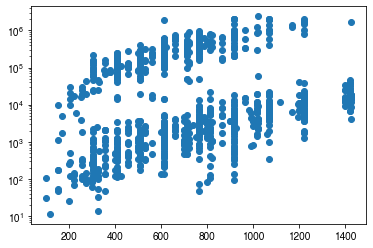

In [46]:
mp.scatter(pipes_df_fix_diam.DiameterInMm, pipes_df_fix_diam.CapacityBOEd)
mp.yscale('log')
#mp.xlim(0,0.1)

### how many could you add by extrapolating capacity?

it's about 15, not really enough to do that, I think

In [47]:
pipes_df_subset = pipes_df_fix_diam.loc[(pipes_df_orig.Status.isin(['Construction','Proposed','Shelved']))&
                                     (pipes_df_orig.Fuel=='Oil')]
pipes_df_subset.loc[(pipes_df_subset['CapacityBOEd'].isna())&
                    (~pipes_df_subset['DiameterInMm'].isna())]['DiameterInMm'].count()

15

that would take it up to about 84% capacity info

In [48]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed','Shelved']))&
                                     (pipes_df_orig.Fuel=='Oil')]
(pipes_df_subset['CapacityBcm/y'].dropna().size + 15) / pipes_df_subset['CapacityBcm/y'].size

0.8349514563106796

### count fraction of available capacity information

count

In [49]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBOEd'].size()
#pipes_df_subset.groupby('StartRegion')['CapacityBcm/y'].size()

StartRegion
Australia and New Zealand          23
East Asia                          92
Eurasia                            62
Europe                             50
Latin America and the Caribbean    30
Middle East and North Africa        8
North America                      97
SE Asia                            11
South Asia                         29
Sub-Saharan Africa                  6
Name: CapacityBOEd, dtype: int64

fraction

In [50]:
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBcm/y'].size()/pipes_df_subset.groupby('StartRegion')['CapacityBOEd'].size()

StartRegion
Australia and New Zealand          0.821429
East Asia                          0.575000
Eurasia                            0.666667
Europe                             0.549451
Latin America and the Caribbean    0.937500
Middle East and North Africa       0.444444
North America                      0.751938
SE Asia                            0.407407
South Asia                         0.725000
Sub-Saharan Africa                 0.300000
dtype: float64

In [51]:
median_capacity = pipes_df_orig['CapacityBcm/y'].median()

In [52]:
abs_dist_from_med_capacity = abs(pipes_df_orig['CapacityBcm/y']-pipes_df_orig['CapacityBcm/y'].median()).median()

In [53]:
pipes_df_orig['CapacityBcm/y'].mean()

251.52531527718943

In [54]:
pipes_df_orig['CapacityBcm/y'].std()

633.6571072405758

In [55]:
print(median_capacity)
print(abs_dist_from_med_capacity)

10.74
10.07


median capacity for a pipeline is about 10.74 bcm/y

median abs dist from the median is about 10.

# cost estimates (pipeline cost per km)

throwing out any estimates larger than USD 10 million per km for taking regional estimates

In [56]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.copy()[(country_ratios_df['Fuel']=='Oil') & 
                                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                                    (country_ratios_df['LengthKnownKmByCountry'].notna()) &
                                    (country_ratios_df['LengthKnownKm']!=0) &
                                    (country_ratios_df['CostUSDPerKm']<10e6)
                                   ]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [57]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

1905976.696103896

### calculate regional costs

In [58]:
pipes_oil_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for region in region_list:
    print(region)
    country_ratios_region_df = country_ratios_with_length_and_cost_df[country_ratios_with_length_and_cost_df['Region']==region]
    pipes_oil_costs_region_df.loc[region]['CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_oil_costs_region_df.loc[region]['NumberOfCosts'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    pipes_oil_costs_region_df.loc[region]['NumberOfLengths'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    

Australia and New Zealand
East Asia
Eurasia
Europe
Latin America and the Caribbean
Middle East and North Africa
North America
SE Asia
South Asia
Sub-Saharan Africa


### table for methodology with regional cost info

In [59]:
pipes_oil_costs_region_df

,CostUSDPerKm,NumberOfCosts,NumberOfLengths
Australia and New Zealand,1214335,6,6
East Asia,1868961,5,5
Eurasia,1854012,6,6
Europe,1083571,5,5
Latin America and the Caribbean,1538293,5,5
Middle East and North Africa,1468246,14,14
North America,2842902,26,26
SE Asia,938922,6,6
South Asia,1711933,5,5
Sub-Saharan Africa,2947993,4,4


### calculate country-level costs

# tables etc.

## table for regional totals

In [60]:
if 'Total' in km_by_region_df.index:
    km_by_region_df.drop(index='Total', inplace=True)   
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

else:
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

km_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Sub-Saharan Africa,4540.09,1950.00,6490.09,986.16,2100.00,8932.05,0.00,0.00,0.00
North America,2692.66,1380.88,4073.54,8311.24,30867.84,126096.14,0.00,0.00,2698.42
Middle East and North Africa,1805.00,1903.00,3708.00,0.00,3587.42,26822.16,0.00,2368.08,1214.51
South Asia,1194.00,2316.00,3510.00,249.40,1692.10,9987.18,0.00,0.00,0.00
East Asia,1046.59,1486.08,2532.67,0.00,8477.06,26292.25,0.00,0.00,6825.55
Eurasia,1494.20,768.23,2262.43,0.00,2635.32,46616.13,0.00,52.00,618.00
Europe,799.90,207.00,1006.90,0.00,8232.21,27955.13,141.55,0.00,0.00
SE Asia,240.49,342.00,582.49,306.00,0.00,2533.36,0.00,0.00,0.00
Australia and New Zealand,0.00,0.00,0.00,0.00,0.00,1878.30,0.00,0.00,187.00
Latin America and the Caribbean,0.00,0.00,0.00,262.00,3730.84,13281.02,0.00,425.00,0.00


## table for km by country

In [61]:
# saves all countries to an Excel file for reference

km_by_country_df.sort_values('Proposed+Construction', ascending=False)

if 'Total' in km_by_country_df.index:
    km_by_country_df.drop(index='Total', inplace=True)   
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

else:
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

km_by_country_df.to_excel('saved-tables/GOIT-km-by-country.xlsx')

# table for stranded asset calculations

## country-level capex estimates

In [62]:
country_ratios_oil_df['CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_oil_df.iterrows():
    # calculate cost
    cntry = row.Country
    region = row.Region
    km_by_cntry = row.LengthKnownKmByCountry
    #print(row.PipelineName)
    country_ratios_oil_df.loc[idx,'CostUSDEstimate'] = pipes_oil_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna())]['LengthKnownKmByCountry'] * \
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna())]['CostUSDPerKm']

country_sums_USDBillion_df = pandas.DataFrame(country_ratios_oil_df.loc[(country_ratios_oil_df.Status.isin(['Construction','Proposed']))].groupby('Country')['CostUSDEstimate'].sum(min_count=1)/1e9)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_45381/808118955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_oil_df['CostUSDEstimate'] = numpy.nan
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a co

In [63]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df.Status==status]
    capex_by_country_df[status] = country_ratios_oil_df_status.groupby('Country')['CostUSDEstimate'].sum()/1e9

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df.Status==status]
    capex_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [64]:
capex_by_region_df['Proposed+Construction'] = capex_by_region_df[['Proposed','Construction']].sum(axis=1)
#capex_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_region_df = capex_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [65]:
capex_by_country_df['Proposed+Construction'] = capex_by_country_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_country_df = capex_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [66]:
if 'Total' in capex_by_region_df.index:
    capex_by_region_df.drop(index='Total', inplace=True)   
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

else:
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

In [67]:
if 'Total' in capex_by_country_df.index:
    capex_by_country_df.drop(index='Total', inplace=True)   
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

else:
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

In [68]:
pandas.options.display.float_format = '{:,.1f}'.format
capex_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,7.5,18.1,25.6,31.9,75.5,343.3,0.0,0.0,7.7
Sub-Saharan Africa,10.0,7.0,17.0,0.0,6.2,22.2,0.0,0.0,0.0
Middle East and North Africa,9.1,2.1,11.2,0.0,3.9,37.5,0.0,3.4,1.8
Europe,7.1,0.1,7.2,0.0,7.1,30.4,0.1,0.0,0.0
South Asia,1.2,4.6,5.8,0.3,2.9,15.1,0.0,0.0,0.0
East Asia,1.8,2.4,4.2,0.0,12.0,46.1,0.0,0.0,9.4
Eurasia,2.8,1.3,4.0,0.0,5.0,80.7,0.0,0.1,1.1
SE Asia,0.0,0.3,0.3,0.4,0.0,2.4,0.0,0.0,0.0
Australia and New Zealand,0.0,0.0,0.0,0.0,0.0,2.1,0.0,0.0,0.2
Latin America and the Caribbean,0.0,0.0,0.0,0.4,7.8,20.8,0.0,0.2,0.0


## print out country-level stranded assets for report discussion

## in-dev for each country in list

In [69]:
#pandas.options.display.float_format = '{:,.1f}'.format
these_countries = ['China','India', 'United States','Russia']

for cntry in these_countries:
    print(cntry)
    cntry_region = country_ratios_df.loc[country_ratios_df.Country==cntry]['Region'].to_list()[0]
    print(km_by_country_df.loc[cntry]['Proposed'], ' km proposed')
    print(km_by_country_df.loc[cntry]['Construction'], ' km in construction')
    print(km_by_country_df.loc[cntry]['Proposed+Construction'], ' total km in development')
    print(country_sums_USDBillion_df.loc[cntry], 'USD')  
    print()
#    country_ratios_df.loc[(country_ratios_df.Status.isin(['Construction','Proposed'])&
#                           (country_ratios_df.
    
#    print(pipes_oil_costs_country_df.loc[cntry]['CostUSDPerKm']*km_by_country_df.loc[cntry]/1e9)
#    print()

China
1046.59  km proposed
1486.08  km in construction
2532.67  total km in development
CostUSDEstimate   4.2
Name: China, dtype: float64 USD

India
1194.0  km proposed
1630.0  km in construction
2824.0  total km in development
CostUSDEstimate   4.0
Name: India, dtype: float64 USD

United States
2692.66  km proposed
136.75  km in construction
2829.41  total km in development
CostUSDEstimate   7.9
Name: United States, dtype: float64 USD

Russia
1494.2  km proposed
557.01  km in construction
2051.21  total km in development
CostUSDEstimate   3.7
Name: Russia, dtype: float64 USD



# numbers for report

## amount already being constructed

In [72]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

0.42841755316947855

In [73]:
# this fraction is on the full database, rather than only the pipelines that we estimate length for
total['Construction']/total['Proposed+Construction']

0.4768098765816466

## total number of pipelines in dev

In [74]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))]['LengthMergedKm'].sum()

24166.07

## top 10 pipelines

In [75]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))].sort_values(
    'LengthKnownKm', ascending=False)[['PipelineName','LengthKnownKm','CapacityBOEd','Countries','Status','StartYearEarliest','Wiki']][:15]



,PipelineName,LengthKnownKm,CapacityBOEd,Countries,Status,StartYearEarliest,Wiki
387,Niger–Benin Oil Pipeline,"1,950.0","90,000.0","Niger, Benin",Construction,2024,https://www.gem.wiki/Niger%E2%80%93Benin_Oil_Pipeline
625,Tazama Oil Pipeline,"1,710.0","22,000.0","Tanzania, Zambia",Proposed,NaN,https://www.gem.wiki/Tazama_Oil_Pipeline
175,Basra-Aqaba Oil Pipeline,"1,665.0","1,000,000.0","Iraq, Jordan",Proposed,NaN,https://www.gem.wiki/Basra-Aqaba_Oil_Pipeline
939,Paradip Numaligarh Crude Pipeline (PNCPL),"1,630.0",NaN,India,Construction,2024,https://www.gem.wiki/Paradip_Numaligarh_Crude_Pipeline_(PNCPL)
172,East African Crude Oil Pipeline (EACOP),"1,444.0","216,000.0","Uganda, Tanzania",Proposed,2025,https://www.gem.wiki/East_African_Crude_Oil_Pipeline_(EACOP)
976,New Mundra–Panipat Oil Pipeline,"1,194.0","430,067.8",India,Proposed,2024,https://www.gem.wiki/New_Mundra%E2%80%93Panipat_Oil_Pipeline
144,Seahorse Pipeline,"1,126.5","800,000.0",United States,Proposed,2022,https://www.gem.wiki/Seahorse_Pipeline
30,Trans Mountain Oil Pipeline,980.0,"290,000.0",Canada,Construction,2023,https://www.gem.wiki/Trans_Mountain_Oil_Pipeline
780,Vostok Oil Pipeline,800.0,NaN,Russia,Proposed,2022,https://www.gem.wiki/Vostok_Oil_Pipeline
777,Willow Oil Pipeline,620.4,"200,000.0",United States,Proposed,2025,https://www.gem.wiki/Willow_Oil_Pipeline


In [76]:
pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))].groupby(['PipelineName','Status','Wiki'])['LengthKnownKm'].sum(min_count=1).sort_values(ascending=False)[:10])

,,,LengthKnownKm
PipelineName,Status,Wiki,
Niger–Benin Oil Pipeline,Construction,https://www.gem.wiki/Niger%E2%80%93Benin_Oil_Pipeline,"1,950.0"
Tazama Oil Pipeline,Proposed,https://www.gem.wiki/Tazama_Oil_Pipeline,"1,710.0"
Basra-Aqaba Oil Pipeline,Proposed,https://www.gem.wiki/Basra-Aqaba_Oil_Pipeline,"1,665.0"
Paradip Numaligarh Crude Pipeline (PNCPL),Construction,https://www.gem.wiki/Paradip_Numaligarh_Crude_Pipeline_(PNCPL),"1,630.0"
East African Crude Oil Pipeline (EACOP),Proposed,https://www.gem.wiki/East_African_Crude_Oil_Pipeline_(EACOP),"1,444.0"
Vostok Oil Pipeline,Proposed,https://www.gem.wiki/Vostok_Oil_Pipeline,"1,400.0"
New Mundra–Panipat Oil Pipeline,Proposed,https://www.gem.wiki/New_Mundra%E2%80%93Panipat_Oil_Pipeline,"1,194.0"
Seahorse Pipeline,Proposed,https://www.gem.wiki/Seahorse_Pipeline,"1,126.5"
Trans Mountain Oil Pipeline,Construction,https://www.gem.wiki/Trans_Mountain_Oil_Pipeline,980.0


In [77]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))].sort_values(
    'LengthMergedKm', ascending=False)[['PipelineName','SegmentName','LengthKnownKm','LengthEstimateKm','CapacityBOEd','Countries','Status','StartYearEarliest','Wiki']][:15]


,PipelineName,SegmentName,LengthKnownKm,LengthEstimateKm,CapacityBOEd,Countries,Status,StartYearEarliest,Wiki
387,Niger–Benin Oil Pipeline,,"1,950.0","1,886.6","90,000.0","Niger, Benin",Construction,2024,https://www.gem.wiki/Niger%E2%80%93Benin_Oil_Pipeline
625,Tazama Oil Pipeline,Expansion,"1,710.0","1,734.8","22,000.0","Tanzania, Zambia",Proposed,NaN,https://www.gem.wiki/Tazama_Oil_Pipeline
175,Basra-Aqaba Oil Pipeline,,"1,665.0","1,663.8","1,000,000.0","Iraq, Jordan",Proposed,NaN,https://www.gem.wiki/Basra-Aqaba_Oil_Pipeline
939,Paradip Numaligarh Crude Pipeline (PNCPL),,"1,630.0","1,459.7",NaN,India,Construction,2024,https://www.gem.wiki/Paradip_Numaligarh_Crude_Pipeline_(PNCPL)
172,East African Crude Oil Pipeline (EACOP),,"1,444.0","1,560.9","216,000.0","Uganda, Tanzania",Proposed,2025,https://www.gem.wiki/East_African_Crude_Oil_Pipeline_(EACOP)
976,New Mundra–Panipat Oil Pipeline,,"1,194.0","1,081.2","430,067.8",India,Proposed,2024,https://www.gem.wiki/New_Mundra%E2%80%93Panipat_Oil_Pipeline
144,Seahorse Pipeline,,"1,126.5","1,127.6","800,000.0",United States,Proposed,2022,https://www.gem.wiki/Seahorse_Pipeline
30,Trans Mountain Oil Pipeline,Trans Mountain Expansion (TMX),980.0,"1,097.4","290,000.0",Canada,Construction,2023,https://www.gem.wiki/Trans_Mountain_Oil_Pipeline
165,Lamu Port-South Sudan (LAPSSET) Pipeline,Lokichar–Lamu Oil Pipeline Segment,NaN,835.3,"65,000.0",Kenya,Proposed,2023,https://www.gem.wiki/Lamu_Port-South_Sudan_(LAPSSET)_Pipeline
780,Vostok Oil Pipeline,Phase I,800.0,623.6,NaN,Russia,Proposed,2022,https://www.gem.wiki/Vostok_Oil_Pipeline


## km of pipeline with 2022, 2023 start years

In [78]:
# for the key points
print(pipes_indev_startyear.loc['Construction',2022],
      pipes_indev_startyear.loc['Construction',2023])

print(pipes_indev_startyear.loc['Proposed',2022],
      pipes_indev_startyear.loc['Proposed',2023])

2179.75 1193.4
2867.86 1347.2800000000004


## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations, so we've used the regional calculation totals instead (193,365.9)

In [79]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Oil')]['LengthMergedKm'].sum()

24166.07

In [80]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Oil') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [81]:
country_ratios_df[(country_ratios_df['Status'].isin(['Proposed','Construction'])) &
               (country_ratios_df['Fuel']=='Oil')]['MergedKmByCountry'].sum()

24166.12

## num in dev globally, whether capacity expansions or not

In [82]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (~pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

capacity expansion projects: (9, 88)
non-zero length projects: (78, 88)


In [83]:
cr = country_ratios_df.loc[(country_ratios_df.Status.isin(['Construction','Proposed']))&
                      (country_ratios_df.Fuel=='Oil')]

In [84]:
cr.loc[cr.MergedKmByPipeline!=0].groupby('ProjectID')['MergedKmByPipeline'].count()

ProjectID
P0033    1
P0358    1
P0531    1
P0538    3
P0541    2
        ..
P3863    1
P3864    1
P3865    1
P3888    1
P3889    1
Name: MergedKmByPipeline, Length: 78, dtype: int64

In [85]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])


print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

481   2,000,000.0
490      62,000.0
491      89,000.0
495     319,478.9
517     150,000.0
635     220,000.0
695      70,000.0
764     250,000.0
890           NaN
Name: CapacityBOEd, dtype: object
                 Countries CapacityBOEd
481           Saudi Arabia  2,000,000.0
490              Argentina     62,000.0
491              Argentina     89,000.0
495     Kazakhstan, Russia    319,478.9
517  Canada, United States    150,000.0
635          United States    220,000.0
695          United States     70,000.0
764          United States    250,000.0
890                  China          NaN
